# Analyzing all of Lewis Hamiltons races and predicting what place he will get

This report will take a dataset from Kaggle called Formula 1 World Championship (1950 - 2024) (Link: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?resource=download) The dataset contains many different csv's with different details, such as the circuits, drivers, and their status. The goal for this model is to take a race that Lewis Hamilton has competed in, and to predict what place he gets, based on specific information and datapoints. I am only going to use a few, namely the drivers, races, and results, as that is all I need. I want to limit the amount of data the model has as much as possible to test the boundaries of how good a ranking prediction can really be. At the moment, I am only planning to give the model the information on the raceId, basically what track its on, the year, month, day, driverId to find Hamilton, and what status he has gotten, basically if he finished the race or not. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef, ConfusionMatrixDisplay, roc_curve, auc, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore")


The first thing I want to do is explore the datasets and see whats in them, I am dropping the columns I don't think are necessary right now. This first dataset I am pretty much only using to find Lewis Hamiltons id, so I can use it in the future, but if I do change this model to predict the placement of any driver, I can refer back to it

In [3]:
# Basicall just to get hamiltons information, maybe if i wannna extend to all dirvers Ill use this fr later?
drivers_df = pd.read_csv('Report-02-data/drivers.csv')
drivers_df.drop(columns=['driverRef','url', 'code', 'nationality', 'number'], inplace=True)
drivers_df

,driverId,forename,surname,dob
0,1,Lewis,Hamilton,1985-01-07
1,2,Nick,Heidfeld,1977-05-10
2,3,Nico,Rosberg,1985-06-27
3,4,Fernando,Alonso,1981-07-29
4,5,Heikki,Kovalainen,1981-10-19
...,...,...,...,...
854,856,Nyck,de Vries,1995-02-06
855,857,Oscar,Piastri,2001-04-06
856,858,Logan,Sargeant,2000-12-31
857,859,Liam,Lawson,2002-02-11


For this one, I am going to first take out all the races before 2007, as that is when Lewis Hamilton started driving. I am also splitting the date column to convert it into three different numbers: year, month, and day.

In [4]:
races_df = pd.read_csv('Report-02-data/races.csv')
races_df = races_df[races_df['year'] >= 2007]
races_df.drop(columns=['round','year', 'circuitId', 'time','url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time','quali_date', 'quali_time', 'sprint_date', 'sprint_time'], inplace=True)
split_columns = races_df['date'].str.split('-', expand=True)
races_df[['year', 'month', 'day']] = split_columns
races_df.drop('date', axis=1, inplace=True)
# races_df['raceId'].value_counts()
races_df

,raceId,name,year,month,day
0,1,Australian Grand Prix,2009,03,29
1,2,Malaysian Grand Prix,2009,04,05
2,3,Chinese Grand Prix,2009,04,19
3,4,Bahrain Grand Prix,2009,04,26
4,5,Spanish Grand Prix,2009,05,10
...,...,...,...,...,...
1120,1140,Mexico City Grand Prix,2024,10,27
1121,1141,São Paulo Grand Prix,2024,11,03
1122,1142,Las Vegas Grand Prix,2024,11,23
1123,1143,Qatar Grand Prix,2024,12,01


This code takes in the results dataset and removes the races where hamilton crashed, just to make ita little easier on the model, so it doesn't have to predict any crashes.

In [5]:
results_df = pd.read_csv('Report-02-data/results.csv')
results_df.drop(columns=['constructorId','number', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'fastestLapTime','fastestLapSpeed'], inplace=True)




hamilton_id = drivers_df[drivers_df['surname'] == 'Hamilton']['driverId'].values[0] 
processed_df = results_df.groupby('raceId').filter(lambda x: hamilton_id in x['driverId'].values)
processed_df.replace(r"\\N", np.nan, regex=True, inplace=True)
processed_df.replace(0, np.nan, regex=True, inplace=True)
processed_df = processed_df.dropna()
processed_df = processed_df[processed_df['raceId'].isin(processed_df[processed_df['driverId'] == hamilton_id]['raceId'])]
processed_df

,resultId,raceId,driverId,grid,position,rank,statusId
0,1,18,1,1.0,1,2,1
1,2,18,2,5.0,2,3,1
2,3,18,3,7.0,3,5,1
3,4,18,4,11.0,4,7,1
4,5,18,5,3.0,5,1,1
...,...,...,...,...,...,...,...
26511,26517,1132,817,15.0,13,15,11
26512,26518,1132,844,11.0,14,9,11
26513,26519,1132,822,16.0,15,18,11
26514,26520,1132,839,18.0,16,16,12


In [6]:
finalraces_df = races_df[races_df['raceId'].isin(processed_df[processed_df['driverId'] == hamilton_id]['raceId'])]
finalraces_df

,raceId,name,year,month,day
1,2,Malaysian Grand Prix,2009,04,05
2,3,Chinese Grand Prix,2009,04,19
3,4,Bahrain Grand Prix,2009,04,26
4,5,Spanish Grand Prix,2009,05,10
5,6,Monaco Grand Prix,2009,05,24
...,...,...,...,...,...
1108,1128,Monaco Grand Prix,2024,05,26
1109,1129,Canadian Grand Prix,2024,06,09
1110,1130,Spanish Grand Prix,2024,06,23
1111,1131,Austrian Grand Prix,2024,06,30


In [7]:
df = finalraces_df.merge(processed_df, on='raceId', how='left')
df.columns

Index(['raceId', 'name', 'year', 'month', 'day', 'resultId', 'driverId',
       'grid', 'position', 'rank', 'statusId'],
      dtype='object')

This is my final function, where I am doing everythin above all at once. I added a little transform function to change the results into the ranges that I want, so the model can classify between two ranges rather than guess a single rank. I am currently doing poidum vs. non-podium finishes, because the ratio of those two is about 1.5:1.

In [8]:
def transform(x):
    if x <= 3:
        return 1
    else:
        return 2

def preprocess():
    races_df = pd.read_csv('Report-02-data/races.csv')
    races_df = races_df[races_df['year'] >= 2007]
    races_df.drop(columns=['name','round','year', 'circuitId', 'time','url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time','quali_date', 'quali_time', 'sprint_date', 'sprint_time'], inplace=True)
    split_columns = races_df['date'].str.split('-', expand=True)
    races_df[['year', 'month', 'day']] = split_columns
    races_df.drop('date', axis=1, inplace=True)
    results_df = pd.read_csv('Report-02-data/results.csv')
    results_df.drop(columns=['constructorId','number', 'positionText', 'positionOrder', 'points', 'laps', 'time',
        'milliseconds', 'fastestLap', 'fastestLapTime','fastestLapSpeed'], inplace=True)


    hamilton_id = drivers_df[drivers_df['surname'] == 'Hamilton']['driverId'].values[0] 
    processed_df = results_df.groupby('raceId').filter(lambda x: hamilton_id in x['driverId'].values)
    processed_df.replace(r"\\N", np.nan, regex=True, inplace=True)
    processed_df.replace(0, np.nan, regex=True, inplace=True)
    processed_df = processed_df.dropna()
    processed_df = processed_df[processed_df['raceId'].isin(processed_df[processed_df['driverId'] == hamilton_id]['raceId'])]
    finalraces_df = races_df[races_df['raceId'].isin(processed_df[processed_df['driverId'] == hamilton_id]['raceId'])]

    df = finalraces_df.merge(processed_df, on='raceId', how='left')
    df = df[df['driverId'] == hamilton_id]
    df['position'] = df['position'].astype(int)
    df['position'] = df['position'].apply(transform)
    df.drop('resultId', axis=1, inplace=True)
    return df

print(preprocess())

      raceId  year month day  driverId  grid  position rank  statusId
6          2  2009    04  05         1  12.0         2   11         1
23         3  2009    04  19         1   9.0         2   12         1
38         4  2009    04  26         1   5.0         2    6         1
62         5  2009    05  10         1  14.0         2    9        11
79         6  2009    05  24         1  19.0         2    8        11
...      ...   ...   ...  ..       ...   ...       ...  ...       ...
5390    1128  2024    05  26         1   7.0         2    0         1
5403    1129  2024    06  09         1   7.0         2    1         1
5415    1130  2024    06  23         1   3.0         1    4         1
5435    1131  2024    06  30         1   5.0         2    7         1
5452    1132  2024    07  07         1   2.0         1    5         1

[315 rows x 9 columns]


Now we're startin the actual ML model. Just as a baseline, I am going to run a Naive Bayes Model, and try to improve my model from there. One important thing I learned from the last report was that I should be looking at the conufsion matrix, not just the accuracy, so I am going to use the matthews_corrcoef, which looks at a confusion matrix and gives it a score bsaed on how good it is. The MCC ($\phi$)  goes by the formula:

$$
\phi = \frac{n_{11}n_{00} - n_{10}n_{01}}{\sqrt{n_{1\bullet}n_{0\bullet}n_{\bullet 0}n_{\bullet 1}}}
$$

I decided to use this value because it gives a straight score to me, instead of making me have to analyze the roc_auc curve every time

Average Cross-Validation Score: 75.01%
Matthews Correlation Coefficient: 33.02%


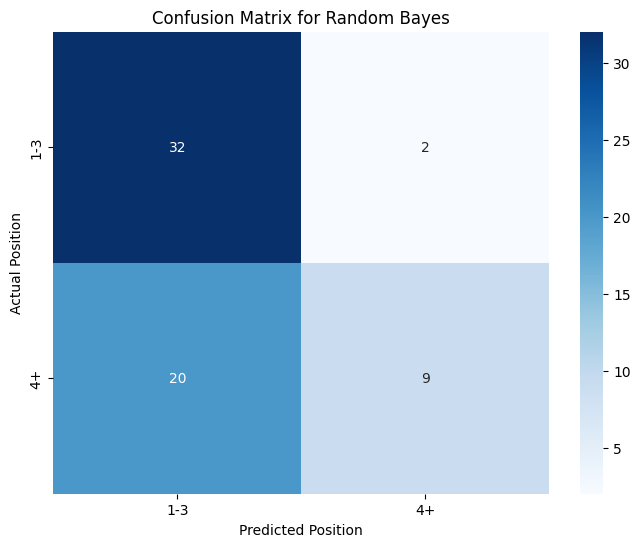

In [9]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


gnb = GaussianNB()

gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(gnb, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Bayes')
plt.show()


Naive Bayes had an accuracy of 74.%, which is actually better than I expected it to. But its matthews_corrcoef was only 30.32%, so I need to make sure to fix the confusion matrix. Before working on the actual model I'm using, I wanna try using a voting classifer with 5 different Naive Bayes to see if it gives a good accuracy.

Average Cross-Validation Score: 75.01%
Matthews Correlation Coefficient: 33.02%


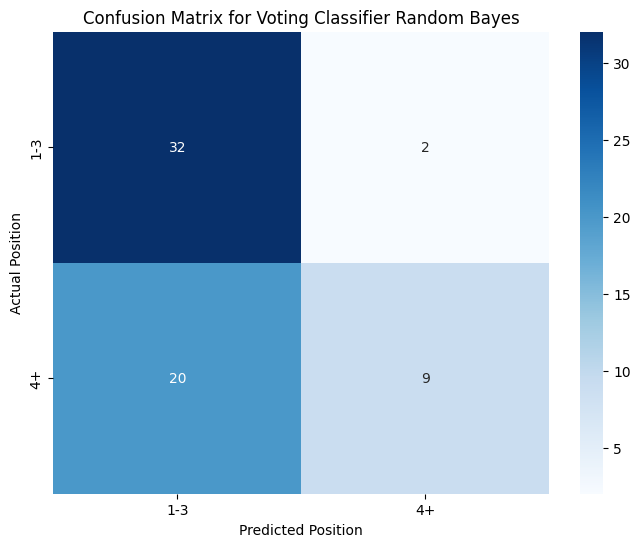

In [10]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_samples = X_train.shape[0]
subsets = []

for i in range(5):
    # Randomly sample with replacement to create bootstrapped subsets
    indices = np.random.choice(n_samples, n_samples, replace=True)
    
    # Use .iloc to correctly slice pandas DataFrame/Series
    subset_X = X_train.iloc[indices].values  # Convert DataFrame to numpy array
    subset_y = y_train.iloc[indices].values  # Convert Series to numpy array
    
    subsets.append((subset_X, subset_y))

gnb1 = GaussianNB()
gnb2 = GaussianNB()
gnb3 = GaussianNB()
gnb4 = GaussianNB()
gnb5 = GaussianNB()

gnb1.fit(subsets[0][0], subsets[0][1])
gnb2.fit(subsets[1][0], subsets[1][1])
gnb3.fit(subsets[2][0], subsets[2][1])
gnb4.fit(subsets[3][0], subsets[3][1])
gnb5.fit(subsets[4][0], subsets[4][1])

voting_clf = VotingClassifier(
    estimators=[
        ('gnb1', gnb1),
        ('gnb2', gnb2),
        ('gnb3', gnb3),
        ('gnb4', gnb4),
        ('gnb5', gnb5)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Voting Classifier Random Bayes')
plt.show()


These actually have the same accuracy and matthews score... I didn't think that it would be like that. My guess is that naive bayes models, no matter really what the dataset is, will end with the same model. Since my idea with naive bayes didnt work, I think I'll start using real models now. Since I have the baseline of 75.01% with Naive Bayes, I wanna also take a baseline of Logistic Regression, KNN, SVM, and a Decision Tree. My prediction is that decision tree is going to be the best, because F1 data is very straightforward, and specific values easily point towards the correct ranking. After getting my baseline, I am going to use gridsearchCV to get the absolute best parameters. Finally, I will use ensemble methods combining the 4, maybe throwing in a Naive Bayes if it makes it better. 

Average Cross-Validation Score: 78.99%
Matthews Correlation Coefficient: 52.59%


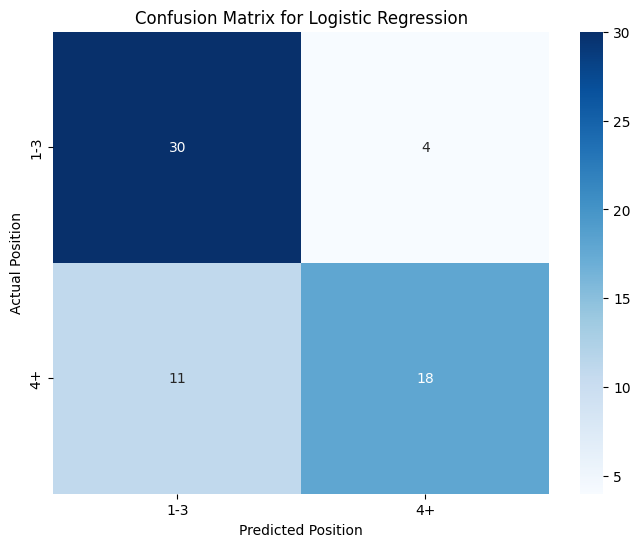

In [11]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter = 1000)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(lr, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Both the accuracy and the matthews score are much better in this one, I think logisitic regression has potential. One thing I've noticed though is that all my models are almost never predicting 4+ when it is really positions 1-3, but predict positions 1-3 when it is 4+ a lot. I think this problem is caused by the datanot being balanced in the dataset, and that is causing the models to predict 1-3 more than 4+. I am going to try gridsearch now, to see if it can make logisitc regression and more importantly, the matthews score better. Sometihng I realized while making this is that I am prioritizing accuracy when using Grid Search CV, I am going to quickly change the models to using a roc_auc scoring method,and see if it makes a differece

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Average Cross-Validation Score: 84.93%
Matthews Correlation Coefficient: 52.59%


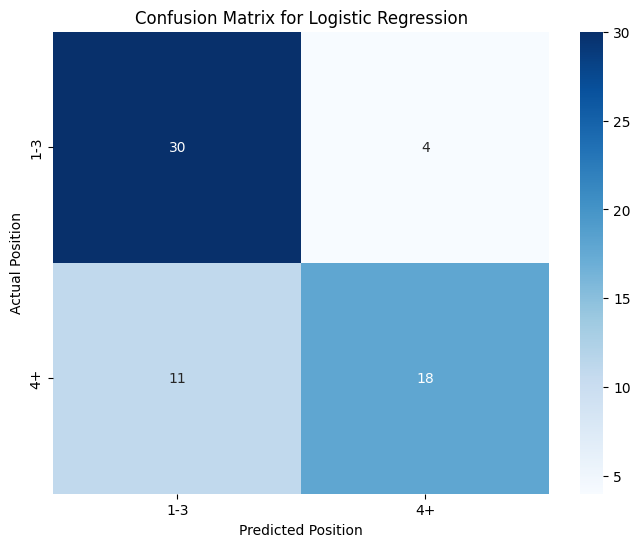

In [34]:
import warnings
warnings.filterwarnings("ignore")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter = 10000)

param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization types
    'C': [0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers to choose from
    'class_weight': [None, 'balanced']
}

# Perform GridSearchCV
grid_searchLR = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_searchLR.fit(X_train, y_train)

y_pred = grid_searchLR.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(grid_searchLR, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [13]:
print("Best Params for Logistic Regression: ", grid_searchLR.best_params_)

Best Params for Logistic Regression:  {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


I really like this model now, it has a very good matthews score that I am content with. I do want to plot the AUC and ROC Curve just to give me a better representation of what the models precision and recall is. I'm  not rly to prioritize either preciison or accuracy, so I'm gonna take the value that gives the best average precision and accuracy.

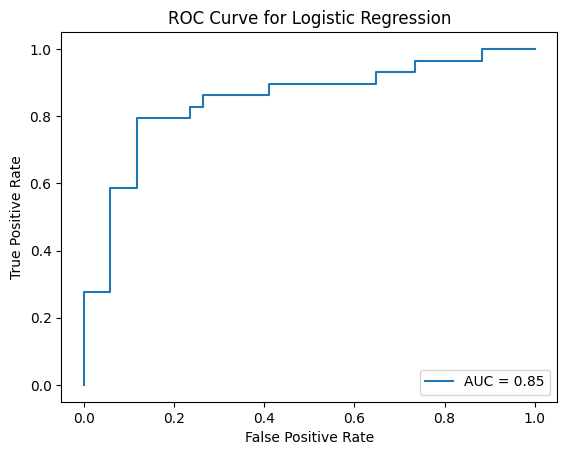

In [14]:
probs = grid_searchLR.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=2)
roc_auc = auc(fpr, tpr)


plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The roc auc curve looks good, I like how the area under curve is .85. I don't think there is much I can do to increase the accuracy of the model using just logistic regression, so I am going to move onto KNN, and do the same thing I just did with LR, hopefully getting a better result.

Average Cross-Validation Score: 69.01%
Matthews Correlation Coefficient: 47.33%


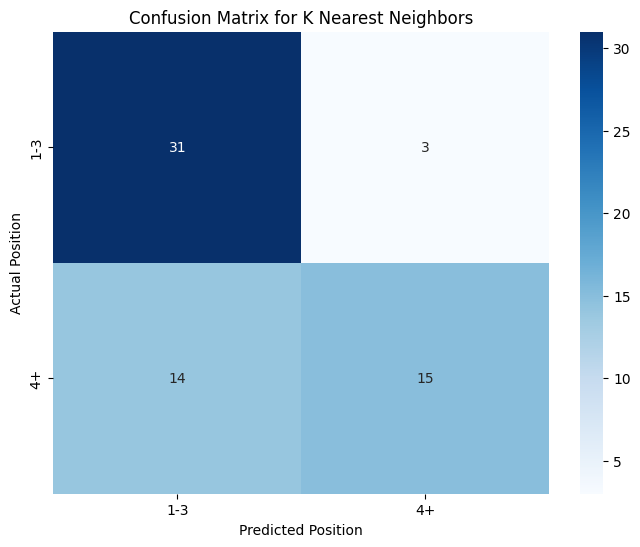

In [15]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(knn, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for K Nearest Neighbors')
plt.show()

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Average Cross-Validation Score: 76.42%
Matthews Correlation Coefficient: 39.04%


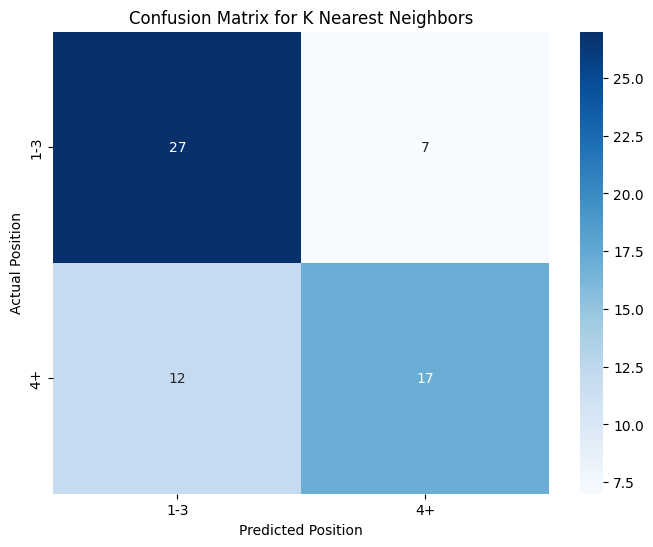

In [16]:
import warnings
warnings.filterwarnings("ignore")

data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute nearest neighbors
    'leaf_size': [20, 30, 40, 50],  # Leaf size for the tree-based algorithms
    'n_jobs': [-1]  # Number of parallel jobs to run (use -1 to use all processors)
}
# Perform GridSearchCV
grid_searchKNN = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_searchKNN.fit(X_train, y_train)

y_pred = grid_searchKNN.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(grid_searchKNN, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for K Nearest Neighbors')
plt.show()

In [17]:
print('Best params for KNN:', grid_searchKNN.best_params_)

Best params for KNN: {'algorithm': 'brute', 'leaf_size': 20, 'n_jobs': -1, 'n_neighbors': 20, 'weights': 'distance'}


So it looks like the KNN Model isn't as good as Logisitc Regression, only maxing at a accuracy of 69.0% and a matthews score of about 35%. The accuracy was a solid 80%, but the matthews score was only 40%, so I think KNN is a bad model. I'm gonna just leave this, and try Decision tree and random forest next. Ive decided not to ues SVMs, becuase its really annoying to make an ROC AUC curve from them.

Average Cross-Validation Score: 69.43%
Matthews Correlation Coefficient: 42.26%


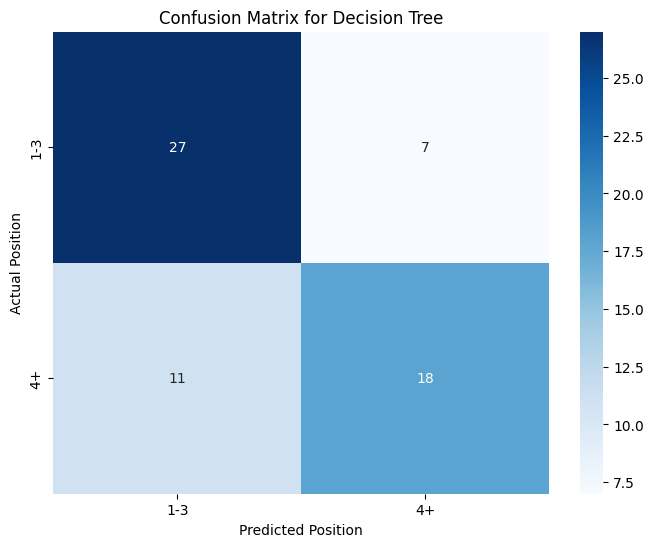

In [18]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(dt, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Average Cross-Validation Score: 72.84%
Matthews Correlation Coefficient: 42.42%


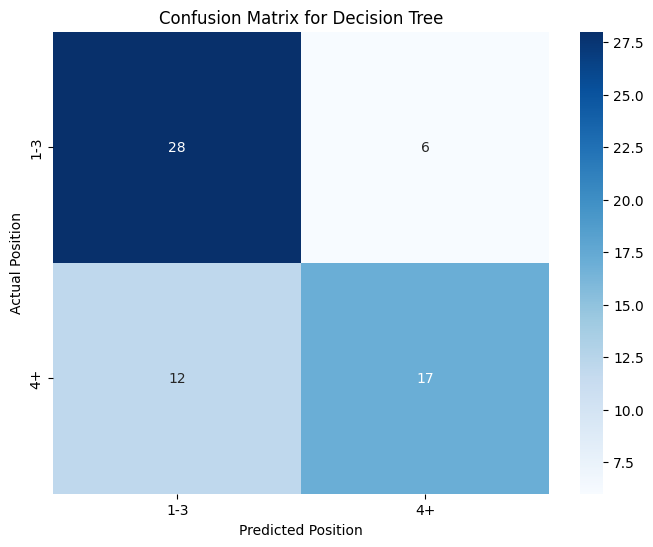

In [19]:
import warnings
warnings.filterwarnings("ignore")

data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
# Perform GridSearchCV
grid_searchDT = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_searchDT.fit(X_train, y_train)

y_pred = grid_searchDT.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(grid_searchDT, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [20]:
print('Best params for Decision Tree:', grid_searchDT.best_params_)

Best params for Decision Tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5}


This model was pretty much just a medium between logisitic regression and knn, but lr is still supremely better. All of my confusion matricies are looking a lot better now, more balanced, but theres still a slight imbalance towards the bottom left of the conufison matrix. I used all the bsaic models now, so I'm gonna start using ensemble methods. First is random forest, then im gonna use all four of the models Ive made to do a voting classifier, boosting, bagging, and eveyrthing I can. I also have an idea to take the 4 ensemble methods I make and make them vote to determine the right answer, but I'll see based on results.

Average Cross-Validation Score: 77.77%
Matthews Correlation Coefficient: 59.27%


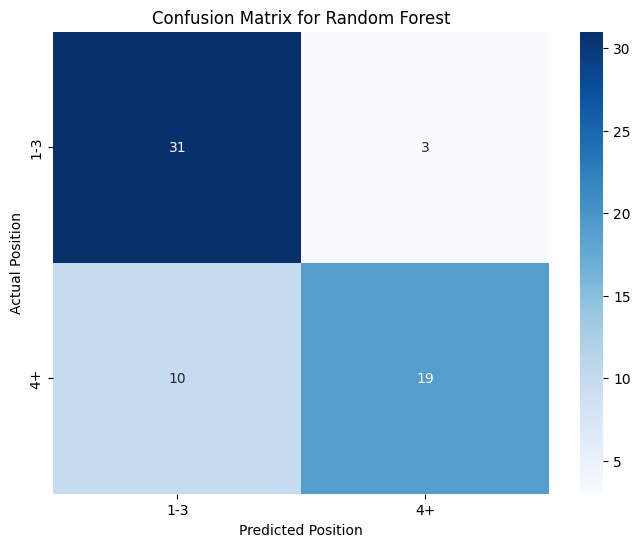

In [21]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

rf1 = RandomForestClassifier()

rf1.fit(X_train, y_train)

y_pred = rf1.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(rf1, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Average Cross-Validation Score: 85.00%
Matthews Correlation Coefficient: 65.96%


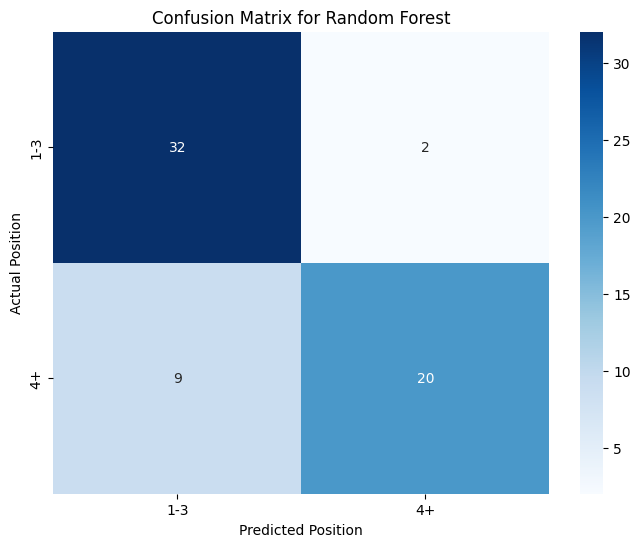

In [22]:
import warnings
warnings.filterwarnings("ignore")

data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'criterion': ['gini', 'entropy'] # Criterion for splitting
}

# Perform GridSearchCV
grid_searchRF = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_searchRF.fit(X_train, y_train)

y_pred = grid_searchRF.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(grid_searchRF, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Random Forest looks like it has potential to me. The normal model has a matthews score of 60%, almost beating I'm gonna plot a ROC_AUC Curve for this to compare it to LR, then move onto creating my voting , bagging, and boosting classifiers. Im using the normal model, not the grid search, since it has a better matthews score

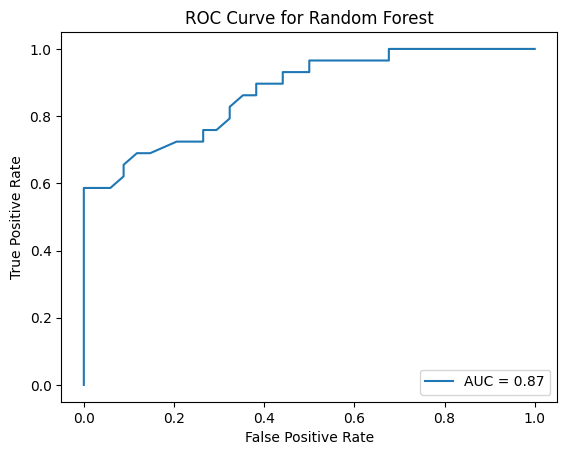

In [23]:
probs = rf1.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=2)
roc_auc = auc(fpr, tpr)


plt.title('ROC Curve for Random Forest')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Wait the AUC is bigger than Logistic Regression, it looks like Random Forest might be better after all, but I think the best one will be combining the 2 models. I am thinking about trying one ensemble method with only the two best (RF and LR), and one with all four models, and seeing which is better

In [24]:
# Best Params for Logistic Regression:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
# Best params for KNN: {'algorithm': 'brute', 'leaf_size': 20, 'n_jobs': -1, 'n_neighbors': 20, 'weights': 'distance'}
# Best params for Decision Tree: {'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}
# Normal Model for Ranodm Forest

data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', LogisticRegression(C = 100, class_weight='balanced', penalty='l2', solver='lbfgs')),
        ('KNN', KNeighborsClassifier(algorithm= 'brute', leaf_size= 20, n_jobs=-1, n_neighbors=20, weights='distance')),
        ('Decision Tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30, min_samples_leaf=4, min_samples_split=10)),
        ('Random Forest', RandomForestClassifier())],
    voting = 'hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=100,
                                                 class_weight='balanced')),
                             ('KNN',
                              KNeighborsClassifier(algorithm='brute',
                                                   leaf_size=20, n_jobs=-1,
                                                   n_neighbors=20,
                                                   weights='distance')),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=30,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10)),
                             ('Random Forest', RandomForestClassifier())])

Logistic Regression = 7.936507936507936%
KNN = 11.11111111111111%
Decision Tree = 12.698412698412698%
Random Forest = 1.5873015873015872%
Voting score = 82.53968253968253%
Average Cross-Validation Score: 76.59%
Matthews Correlation Coefficient: 67.00%


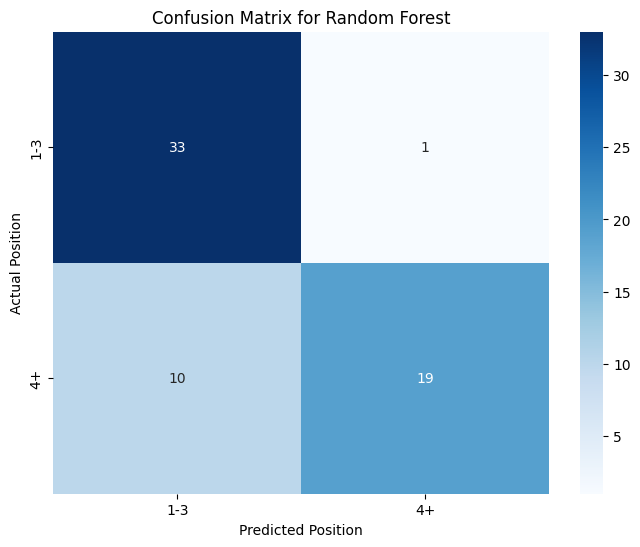

In [25]:
for name, clf in voting_clf.named_estimators_.items():
    print(f"{name} = {clf.score(X_test, y_test) * 100}%")
print(f"Voting score = {voting_clf.score(X_test, y_test) * 100}%")

y_pred = voting_clf.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Forest')
plt.show()

You can see in the comments above the best parameters for each model, and I used the normal model for Random Forest because it was the best with matthews score. The results shown make sense mostly, but the thing I am very confused about is the individual scores of the models. It says:

Logistic Regression = 7.936507936507936% 

KNN = 11.11111111111111%

Decision Tree = 12.698412698412698% 

Random Forest = 1.5873015873015872%


But I had just ran the exact same models above, and got much higher accuracies. I couldn't figure out why this happened, so I'm planning to come back to it later if I have time to investigate. Im gonna first make my bagging and other ensemble models to which is the best. Since Logistic Regression was my best model, Im gonna use it in the bagging model

Accuracy of Bagging 500 Logistic Regressions:  0.8253968253968254
Average Cross-Validation Score: 78.97%
Matthews Correlation Coefficient: 64.98%


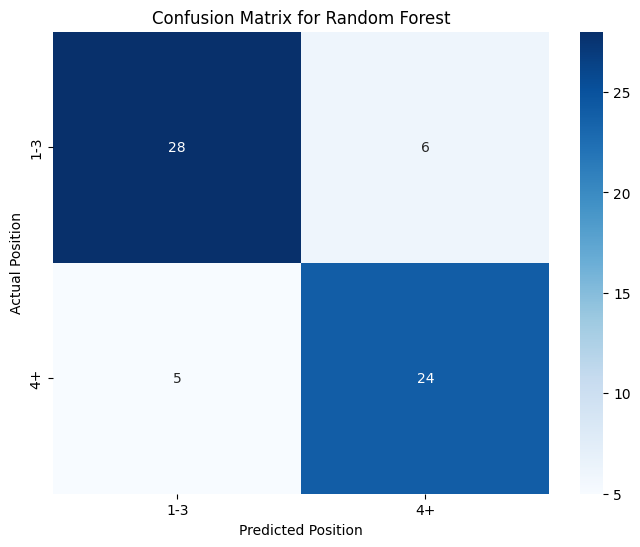

In [26]:
bag_clf = BaggingClassifier(LogisticRegression(C = 100, class_weight='balanced', penalty='l2', solver='lbfgs'), n_estimators = 100, max_samples = 100, random_state=42)

bag_clf.fit(X_train, y_train)
print("Accuracy of Bagging 500 Logistic Regressions: ", bag_clf.score(X_test, y_test))


y_pred = bag_clf.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(bag_clf, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Wow, it has the exact same matthews score as Logisitc Regresoin, but a lower accuracy. Somehow, Logistic Regression is still my best model. I think this is because the data is very distinct, and drawing a single sigmoid function will let you classify relatively well. I am going to make my Boosting method next. First, lets see how important each feature is in the Logistic Regression

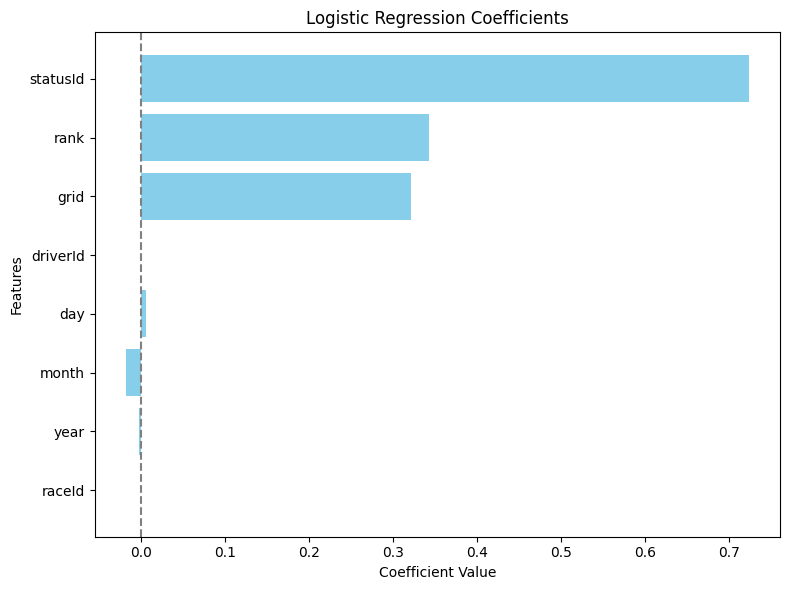

In [27]:
lr = LogisticRegression(C = 100, class_weight='balanced', penalty='l2', solver='lbfgs')
lr.fit(X_train, y_train)

feature_names = X.columns
coefficients = lr.coef_[0]

# Plot Coefficients
plt.figure(figsize=(8, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Logistic Regression Coefficients")
plt.axvline(0, color='grey', linestyle='--')  # Vertical line at zero for reference
plt.tight_layout()
plt.show()

So the reason I just plotted this was to see what was realy even importatnt in the model, I see that the driverId, the raceId, and year are not very important and provide almost no value. This really surprised me, because I was really sure that the raceId would make a difference, maybe different races through Lewis Hamiltons life would change based on how late or early they were. Maybe he got better as time went on, because he wwas more expeinenced, and maybe his last races would be worse because he;s getting old. I like the coefficients though, we arent relying only on one, its more of a split between statusId, rank, and grid. Now im gonna try using Boosting

Average Cross-Validation Score: 75.00%
Matthews Correlation Coefficient: 45.91%


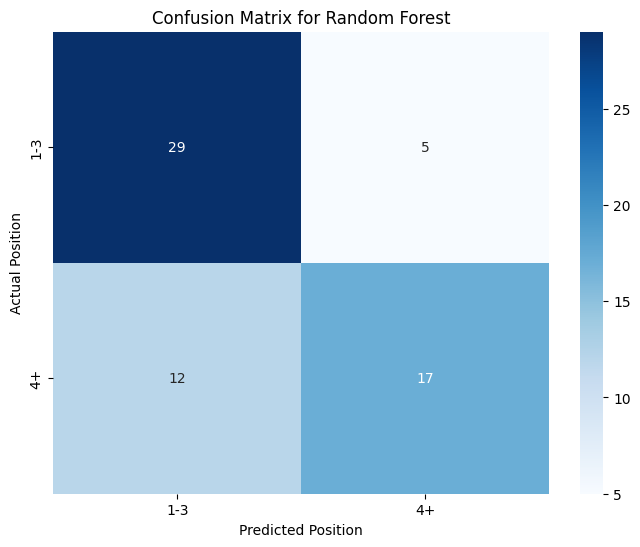

In [28]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

gb_clf = GradientBoostingClassifier(random_state = 42)
gb_clf.fit(X_train, y_train)


y_pred = gb_clf.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(gb_clf, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Im really surprised, this confusion matrix looks really bad compared to the ones we got from other Ensemble methods. I think its because the model is being overfitted to fpcus on accuracy rather than the correlation coefficients. Maybe I can try running a GridSearchCV later on all the models to see if it makes it better? Either way, im gonna try to stack right now, and then go back to the idea of GridSearching an ensemble method.

Stacked accuracy:  0.6825396825396826
Individual Accuracies

Logistic Regression = 7.936507936507936%
KNN = 11.11111111111111%
Decision Tree = 11.11111111111111%
Random Forest = 6.349206349206349%
Average Cross-Validation Score: 65.48%
Matthews Correlation Coefficient: 37.04%


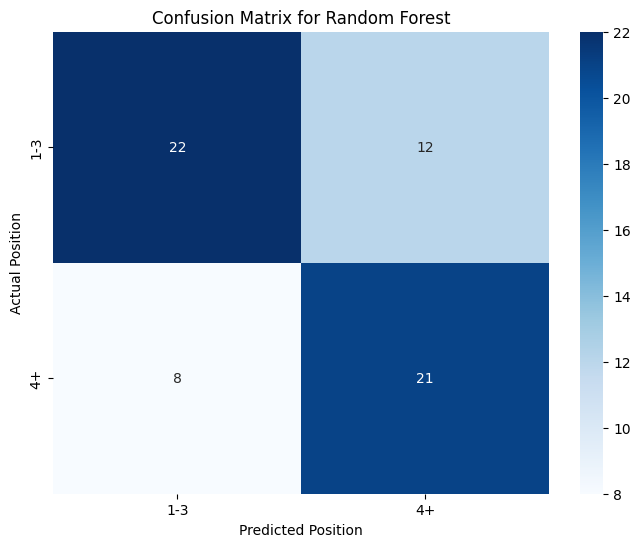

In [29]:
data = preprocess()
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

stacking_clf = StackingClassifier(
    estimators=[
        ('Logistic Regression', LogisticRegression(C = 100, class_weight='balanced', penalty='l2', solver='lbfgs')),
        ('KNN', KNeighborsClassifier(algorithm= 'brute', leaf_size= 20, n_jobs=-1, n_neighbors=20, weights='distance')),
        ('Decision Tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30, min_samples_leaf=4, min_samples_split=10)),
        ('Random Forest', RandomForestClassifier())],
    final_estimator= MLPClassifier(random_state=42, hidden_layer_sizes=(40,10,5), learning_rate='adaptive', max_iter=1000),
    cv = 5
)

stacking_clf.fit(X_train, y_train)

print("Stacked accuracy: ", stacking_clf.score(X_test, y_test))
print("Individual Accuracies\n")
for name, clf in stacking_clf.named_estimators_.items():
    print(f"{name} = {clf.score(X_test, y_test)*100}%")

    
y_pred = stacking_clf.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Random Forest')
plt.show()

This has the same problem.. Why are the individual accuracies so weird? I have no clue why this is happening, and im just gonna leave stacking as it is. maybe its a problem with the actual .score() method, but I cannot figure out what I am doing wrong.

My next idea is to try to take the top 3 features that I got from logistic regression, and rerun logistic regression with it. LR is the best model I have right now, it has te best accuracy and matthews coefficient, and if it wil work faster with less features, I am going to see if I can increase the parameter grid on it, so I can get a better model.

I am dropping the driverId, raceId, day, and year columns, and I will compare the original accuracy and matthews score of 84% accuracy and 65% score

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Average Cross-Validation Score: 84.47%
Matthews Correlation Coefficient: 64.98%
Best Parameters {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


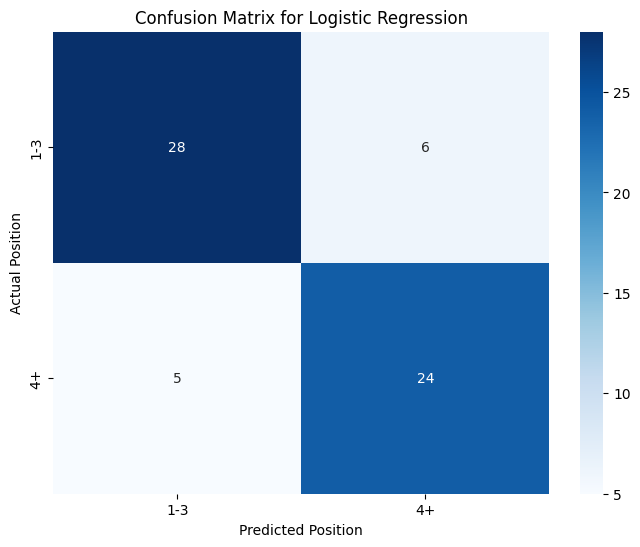

In [35]:
import warnings
warnings.filterwarnings("ignore")

data = preprocess()
data.drop(['driverId','raceId','day','year'], axis=1)
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter = 10000)

param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization types
    'C': [0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Solvers to choose from
    'class_weight': [None, 'balanced']
}

# Perform GridSearchCV
grid_searchLR = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_searchLR.fit(X_train, y_train)

y_pred = grid_searchLR.predict(X_test)

classes = ['1-3', '4+']

cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(grid_searchLR, X_train, y_train, cv=5)  # 5-fold cross-validation

print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc = matthews_corrcoef(y_test, y_pred)

print(f'Matthews Correlation Coefficient: {mcc * 100 :.2f}%')

print('Best Parameters', grid_searchLR.best_params_)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

This actually really surprised me, as I got the same parameters, accuracy, and matthews score with only four coefficients in my logistic regression model. Maybe all I really need to know is the month for the race to see the weather, maybe Hamilton is better in some weathers than others, the status of his car, basically if he finished or not, his inital position at the start of the race, and his 'rank', as in his fastest lap compared to other drivers's fastest lap. I think I am going to leave this project for now, but I really want to come back to this later and try to add another column saying who he is versuing, but I haven't thought about how I am going to implement that yet.

# Final Model

Average Cross-Validation Score: 79.37%
Matthews Correlation Coefficient: 54.73%


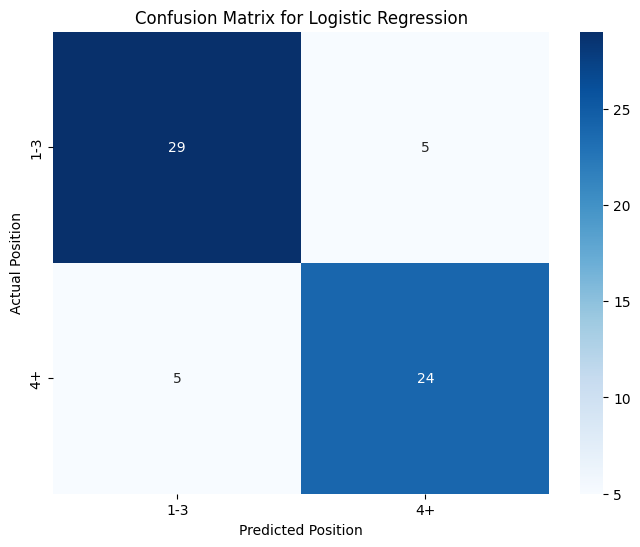

In [31]:
data = preprocess()
data.drop(['driverId','raceId','day','year'], axis=1)
y = data['position']
X = data.drop('position', axis=1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
lr = LogisticRegression(C = 100, class_weight='balanced', penalty='l2', solver='lbfgs')

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

cv_scores = cross_val_score(lr, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f'Average Cross-Validation Score: {np.mean(cv_scores) * 100:.2f}%')

mcc_scorer = make_scorer(matthews_corrcoef)
mcc_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=mcc_scorer)
average_mcc = np.mean(mcc_scores)
print(f'Matthews Correlation Coefficient: {average_mcc * 100 :.2f}%')

classes = ['1-3', '4+']
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Position')
plt.ylabel('Actual Position')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

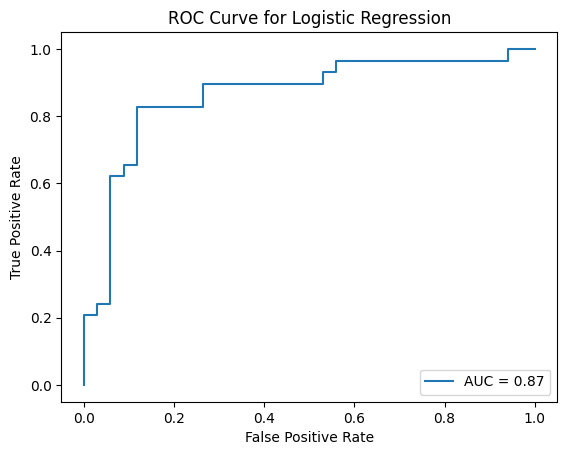

In [32]:
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=2)
roc_auc = auc(fpr, tpr)


plt.title('ROC Curve for Logistic Regression')
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

My final model is a Logistic Regression with the parameters: C = 100, class_weight='balanced', penalty='l2', solver='lbfgs'. I got a final confusion matrix with an accuracy of 79.37%, with a matthews corelation coefficient of 54.73%. It seems lower than the old tests because I ran a cross validation on the matthews score to get a more generalized score. My roc curve is realtively close to the top left of the graph, and I am happy with where my model is right now. My area under curve is 0.88, which is better than the initlal models that I had, so I think Im close to the limits of the models we know right now. I want to try to make it better in the future, but I dont know if I can make a whole project out of it, so I might do it on my own free time. Maybe I can add a list of the drivers hamilton faced and see if the model can make sense of it.